In [1]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('PYTHONPATH'))

from model.configs.config import config
from utils.DataLoader import DataLoader
from utils.DataEDA import EDAStatisticalAnalysis, EDAGraphicalAnalysis


# configuration  path data
base_path = '../../..'  #main path to the project
original_data_path = config['input_paths']['raw_data_path'].format(base_path=base_path)
proccessed_original_data_path = config['output_paths']['proccessed_original_data_path'].format(base_path=base_path)


In [2]:

def reshape_data(df):
    df_long = df.melt(id_vars=['Experimento', 'Sensor', 'Valor de referencia(Cm)'], 
                        value_vars=[f'M{i}' for i in range(1, 16)],
                        var_name='Sensor_Medicion', value_name='Medicion')
    df_long['Medicion_Numero'] = df_long['Sensor_Medicion'].str.extract(r'(\d+)').astype(int)
    df_long = df_long.drop(columns=['Sensor_Medicion'])
    df_long = df_long[['Experimento', 'Sensor', 'Valor de referencia(Cm)', 'Medicion_Numero', 'Medicion']]
    return df_long


data_csv = DataLoader.load_data_csv(original_data_path)
new_csv = reshape_data(data_csv)

DataLoader.save_data_to_csv(new_csv, proccessed_original_data_path)
print(new_csv.columns)
tablaSensor1 = new_csv[new_csv['Sensor'] == 0]
tablaSensor2 = new_csv[new_csv['Sensor'] == 1]

Index(['Experimento', 'Sensor', 'Valor de referencia(Cm)', 'Medicion_Numero',
       'Medicion'],
      dtype='object')


In [3]:
# 3.1: Resumen estadístico y correlación
df = tablaSensor1
reference_col = 'Valor de referencia(Cm)'
measurement_cols = ["Medicion"]

""" df = data_csv
reference_col = 'Valor de referencia(Cm)'
measurement_cols = [col for col in df.columns if 'M' in col] """

" df = data_csv\nreference_col = 'Valor de referencia(Cm)'\nmeasurement_cols = [col for col in df.columns if 'M' in col] "

In [4]:


#  Análisis gráfico
stats_summary = EDAStatisticalAnalysis.summary_statistics(df, reference_col, measurement_cols)
print("Estadísticas Descriptivas:", stats_summary["Descriptive Statistics"])
print("Matriz de Correlación:", stats_summary["Correlation Matrix"])

#  Análisis de errores
error_abs, error_rel = EDAStatisticalAnalysis.error_analysis(df, reference_col, measurement_cols)
print("Errores Absolutos:", error_abs)
print("Errores Relativos:", error_rel)

#  Regresión lineal
model, predictions = EDAStatisticalAnalysis.linear_regression_model(df, reference_col, measurement_cols)
validation_metrics = EDAStatisticalAnalysis.model_validation(df[reference_col] , predictions)
print("Métricas de Validación:", validation_metrics)

# ANOVA (si hay más de una columna de mediciones)
if len(measurement_cols) > 1:
    f_val, p_val = EDAStatisticalAnalysis.anova_test(df, measurement_cols)
    print(f"Resultado ANOVA: F-valor = {f_val}, P-valor = {p_val}")
 


Estadísticas Descriptivas:        Experimento  Sensor  Valor de referencia(Cm)  Medicion_Numero  \
count   240.000000   240.0               240.000000       240.000000   
mean      1.500000     0.0                17.875000         8.000000   
std       0.501045     0.0                10.936532         4.329523   
min       1.000000     0.0                 3.000000         1.000000   
25%       1.000000     0.0                 8.750000         4.000000   
50%       1.500000     0.0                17.500000         8.000000   
75%       2.000000     0.0                26.250000        12.000000   
max       2.000000     0.0                35.000000        15.000000   

         Medicion  
count  240.000000  
mean    18.595833  
std     11.100114  
min      3.000000  
25%      9.000000  
50%     18.000000  
75%     27.000000  
max     37.000000  
Matriz de Correlación:                           Experimento  Sensor  Valor de referencia(Cm)  \
Experimento              1.000000e+00     NaN  

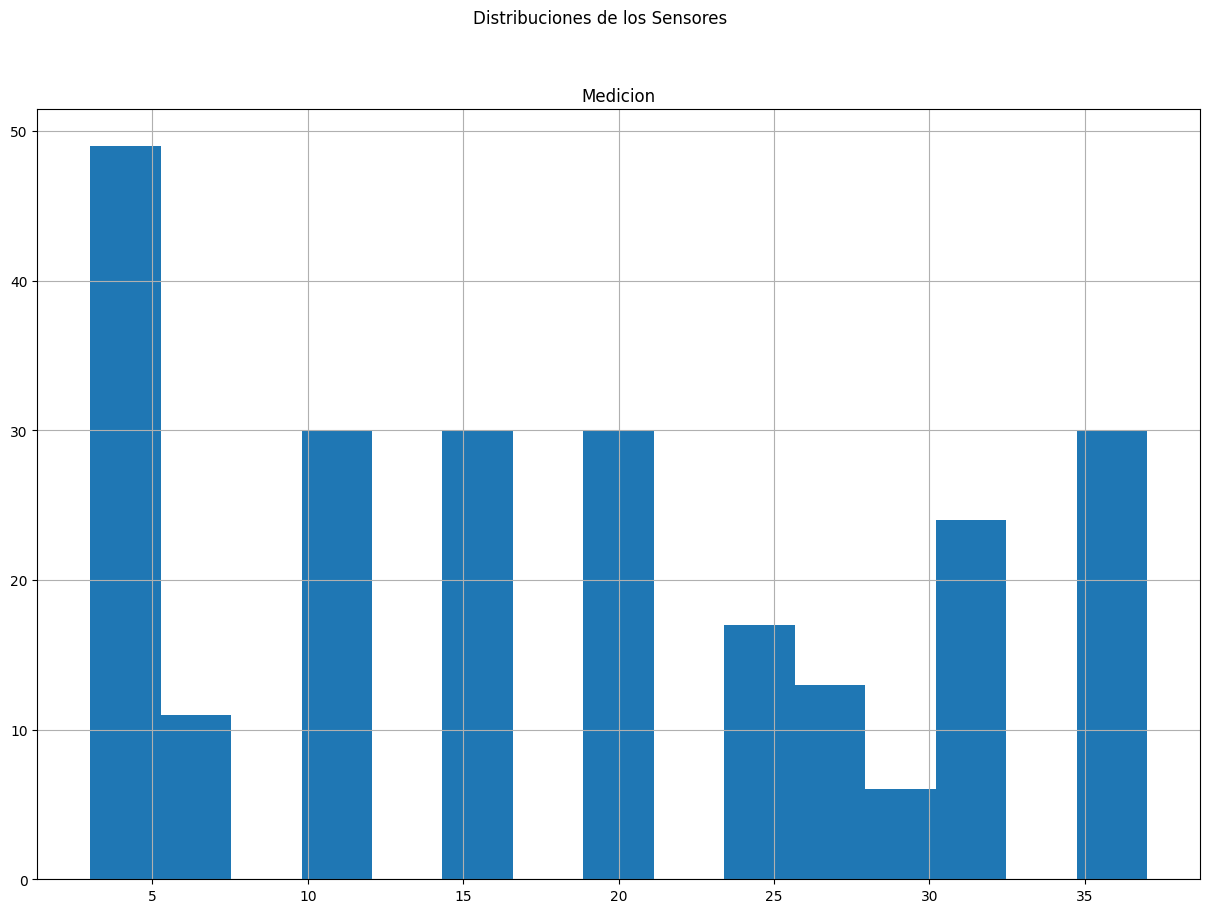

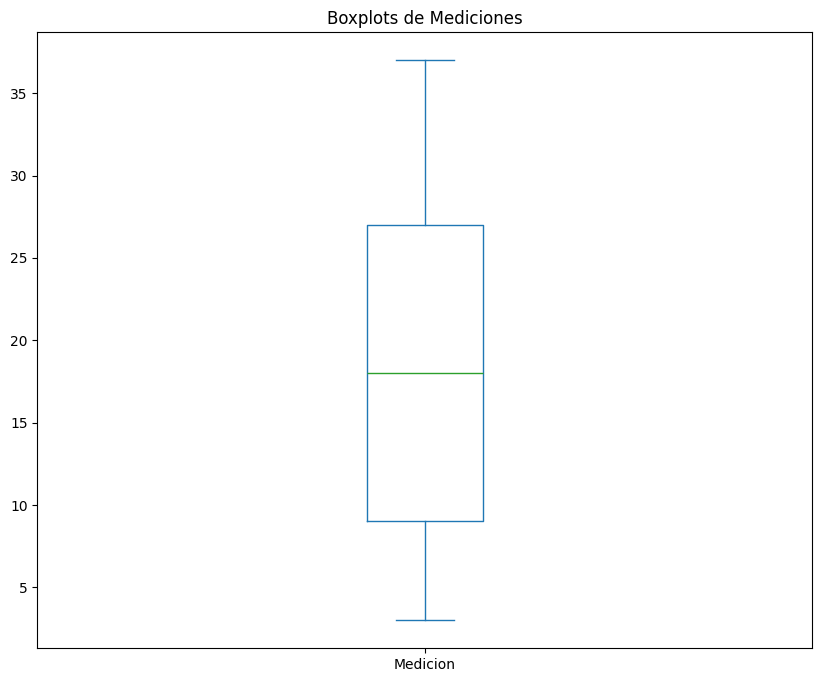

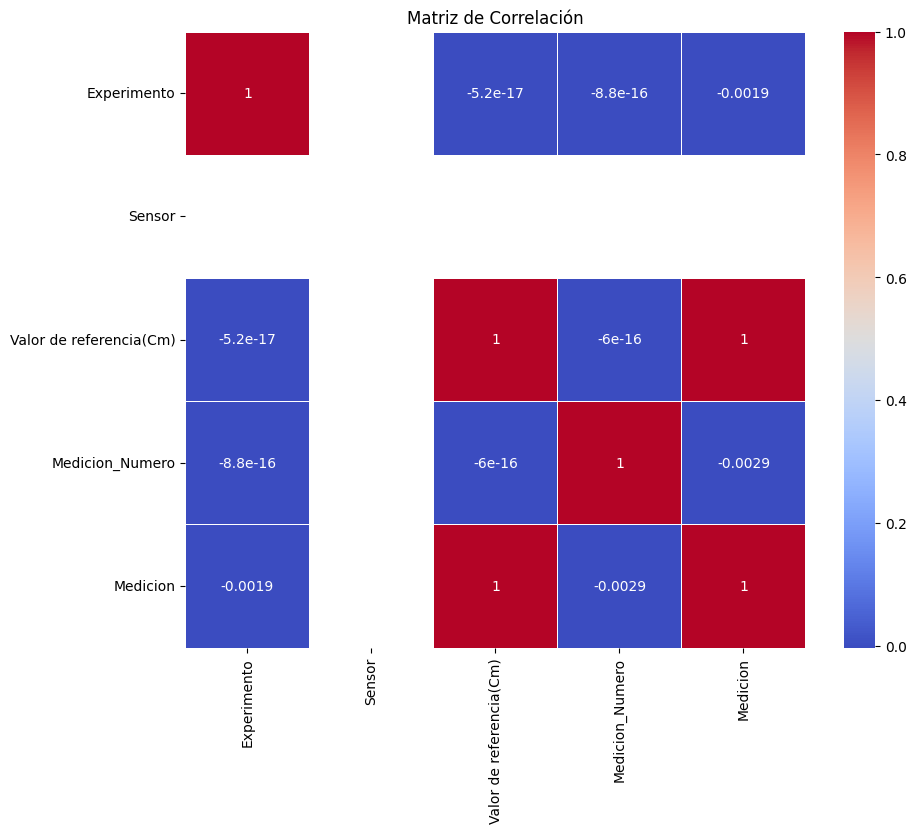

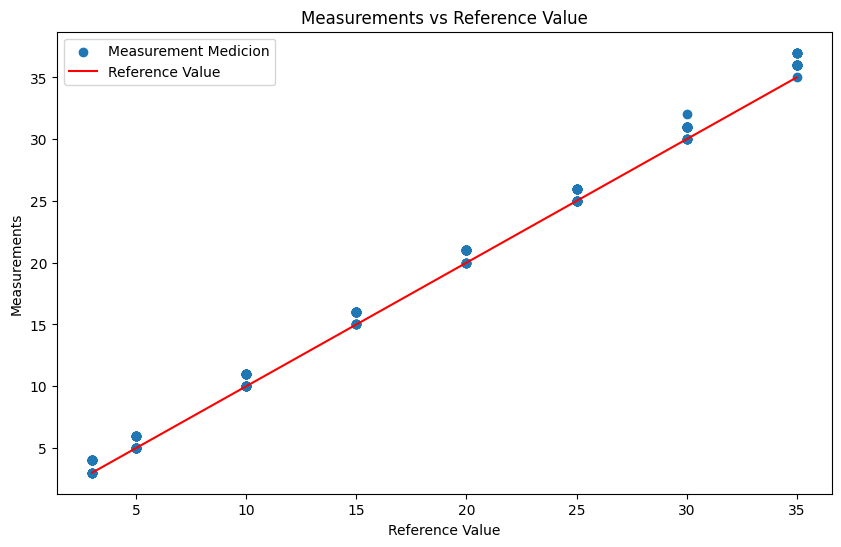

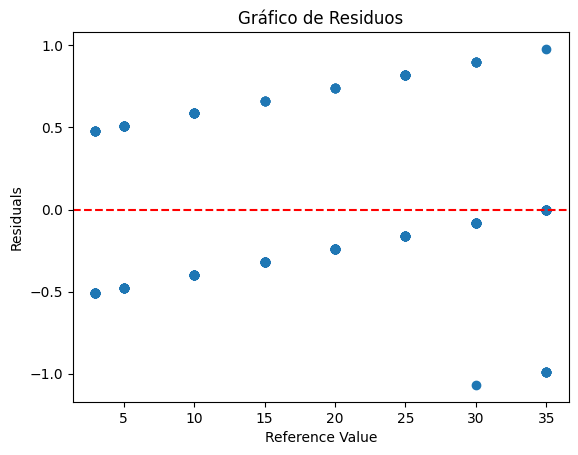

In [5]:
# Paso 4: Generar Visualizaciones

# 4.1: Histogramas de distribución
EDAGraphicalAnalysis.plot_distributions(df, measurement_cols, title='Distribuciones de los Sensores')

# 4.2: Boxplots para las mediciones
EDAGraphicalAnalysis.plot_boxplots(df, measurement_cols, title='Boxplots de Mediciones')

# 4.3: Matriz de correlación
EDAGraphicalAnalysis.plot_correlation_matrix(df, title='Matriz de Correlación')

# 4.4: Gráfico de errores (dispersión)
EDAGraphicalAnalysis.plot_error_trends(df, reference_col, measurement_cols)

# 4.5: Gráfico de residuos del modelo
residuals = EDAStatisticalAnalysis.residual_analysis(df[reference_col], predictions)
EDAGraphicalAnalysis.plot_residuals(df[reference_col], residuals, title='Gráfico de Residuos')

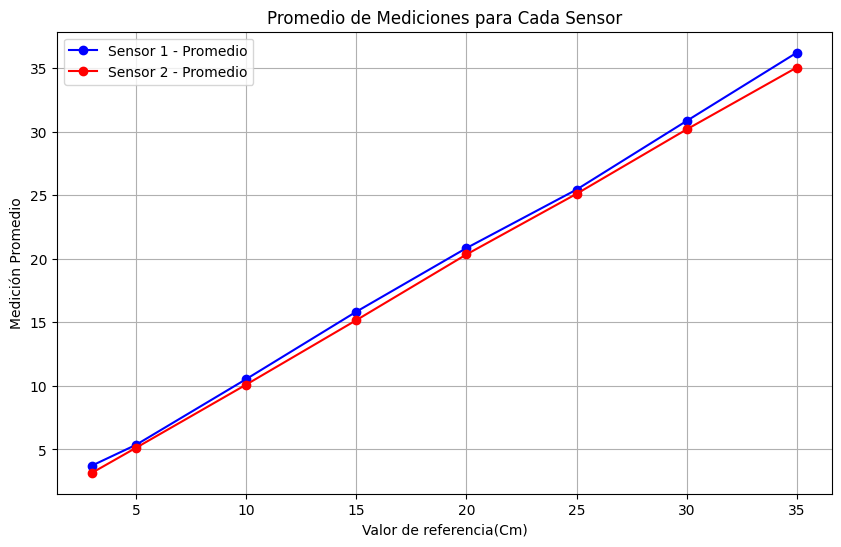

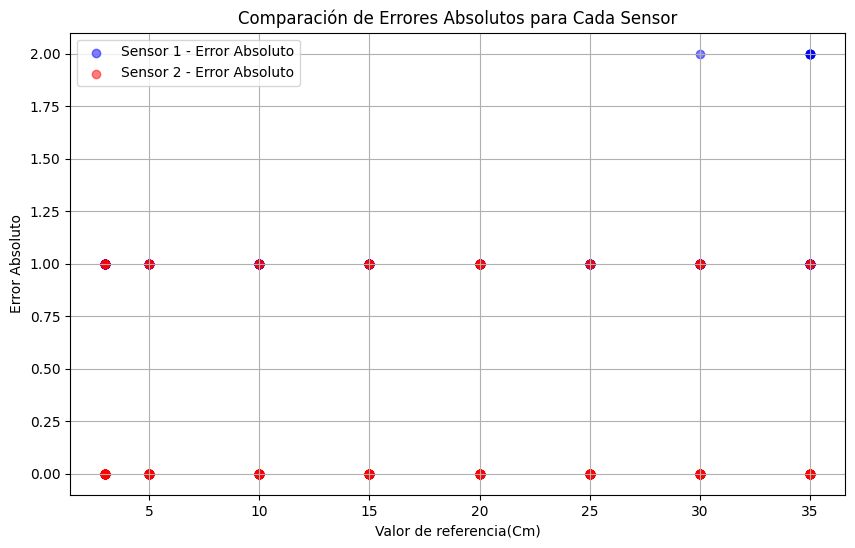

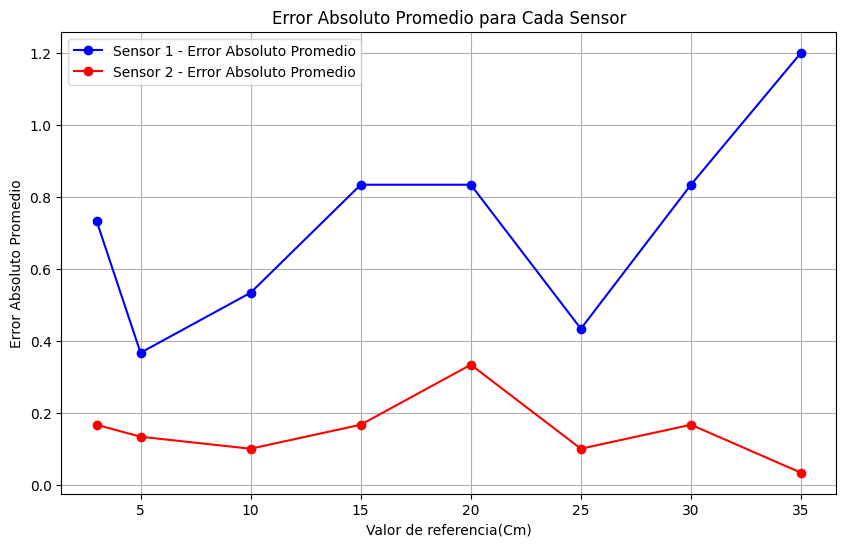

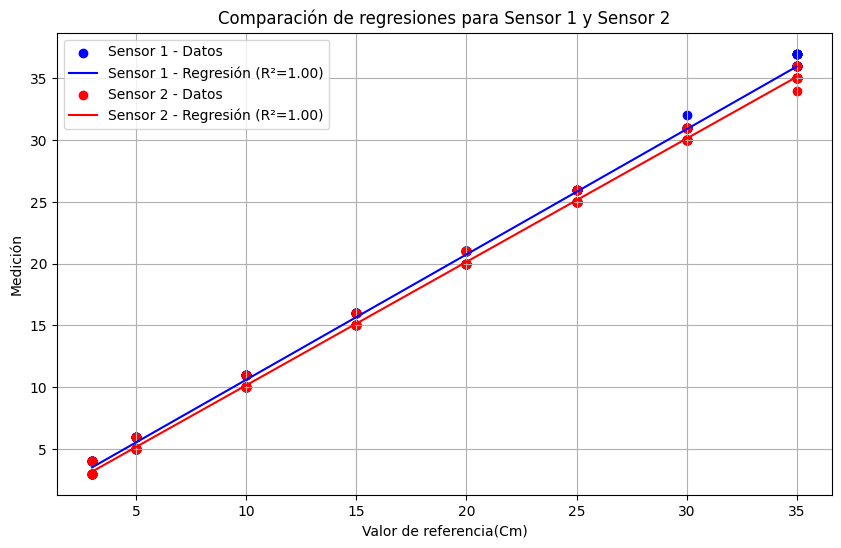

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_comparative_regressions(sensor_data1, sensor_data2, reference_col, measurement_col):
    # Crear el modelo de regresión lineal para el sensor 1
    X1 = sensor_data1[reference_col].values.reshape(-1, 1)
    y1 = sensor_data1[measurement_col].values
    model1 = LinearRegression().fit(X1, y1)
    predictions1 = model1.predict(X1)

    # Crear el modelo de regresión lineal para el sensor 2
    X2 = sensor_data2[reference_col].values.reshape(-1, 1)
    y2 = sensor_data2[measurement_col].values
    model2 = LinearRegression().fit(X2, y2)
    predictions2 = model2.predict(X2)

    # Crear el gráfico comparativo
    plt.figure(figsize=(10, 6))
    
    # Plot para Sensor 1
    plt.scatter(sensor_data1[reference_col], sensor_data1[measurement_col], color='blue', label='Sensor 1 - Datos')
    plt.plot(sensor_data1[reference_col], predictions1, color='blue', label=f'Sensor 1 - Regresión (R²={model1.score(X1, y1):.2f})')

    # Plot para Sensor 2
    plt.scatter(sensor_data2[reference_col], sensor_data2[measurement_col], color='red', label='Sensor 2 - Datos')
    plt.plot(sensor_data2[reference_col], predictions2, color='red', label=f'Sensor 2 - Regresión (R²={model2.score(X2, y2):.2f})')

    # Añadir títulos y leyenda
    plt.title('Comparación de regresiones para Sensor 1 y Sensor 2')
    plt.xlabel(reference_col)
    plt.ylabel('Medición')
    plt.legend()
    plt.grid(True)
    plt.show()


import matplotlib.pyplot as plt

# 1. Gráfico de Línea de Promedio de Mediciones para Cada Sensor
def plot_mean_measurements(sensor_data1, sensor_data2, reference_col):
    plt.figure(figsize=(10, 6))
    
    # Calcular promedios por valor de referencia
    mean_sensor1 = sensor_data1.groupby(reference_col)['Medicion'].mean()
    mean_sensor2 = sensor_data2.groupby(reference_col)['Medicion'].mean()
    
    plt.plot(mean_sensor1.index, mean_sensor1, marker='o', color='blue', label='Sensor 1 - Promedio')
    plt.plot(mean_sensor2.index, mean_sensor2, marker='o', color='red', label='Sensor 2 - Promedio')
    
    plt.title('Promedio de Mediciones para Cada Sensor')
    plt.xlabel(reference_col)
    plt.ylabel('Medición Promedio')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Gráfico de Dispersión para Errores Absolutos
def plot_absolute_errors(sensor_data1, sensor_data2, reference_col):
    plt.figure(figsize=(10, 6))
    
    # Calcular errores absolutos
    error_sensor1 = abs(sensor_data1[reference_col] - sensor_data1['Medicion'])
    error_sensor2 = abs(sensor_data2[reference_col] - sensor_data2['Medicion'])
    
    plt.scatter(sensor_data1[reference_col], error_sensor1, color='blue', alpha=0.5, label='Sensor 1 - Error Absoluto')
    plt.scatter(sensor_data2[reference_col], error_sensor2, color='red', alpha=0.5, label='Sensor 2 - Error Absoluto')
    
    plt.title('Comparación de Errores Absolutos para Cada Sensor')
    plt.xlabel(reference_col)
    plt.ylabel('Error Absoluto')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Gráfico de Línea de Error Absoluto Promedio
def plot_mean_absolute_errors(sensor_data1, sensor_data2, reference_col):
    plt.figure(figsize=(10, 6))
    
    # Calcular error absoluto promedio por valor de referencia
    mean_abs_error_sensor1 = abs(sensor_data1.groupby(reference_col)['Medicion'].mean() - sensor_data1.groupby(reference_col)[reference_col].mean())
    mean_abs_error_sensor2 = abs(sensor_data2.groupby(reference_col)['Medicion'].mean() - sensor_data2.groupby(reference_col)[reference_col].mean())
    
    plt.plot(mean_abs_error_sensor1.index, mean_abs_error_sensor1, marker='o', color='blue', label='Sensor 1 - Error Absoluto Promedio')
    plt.plot(mean_abs_error_sensor2.index, mean_abs_error_sensor2, marker='o', color='red', label='Sensor 2 - Error Absoluto Promedio')
    
    plt.title('Error Absoluto Promedio para Cada Sensor')
    plt.xlabel(reference_col)
    plt.ylabel('Error Absoluto Promedio')
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a las funciones con los datos de los sensores
plot_mean_measurements(tablaSensor1, tablaSensor2, 'Valor de referencia(Cm)')
plot_absolute_errors(tablaSensor1, tablaSensor2, 'Valor de referencia(Cm)')
plot_mean_absolute_errors(tablaSensor1, tablaSensor2, 'Valor de referencia(Cm)')
plot_comparative_regressions(tablaSensor1, tablaSensor2, 'Valor de referencia(Cm)', 'Medicion')
